In [1]:
import json
import os
import random
from argparse import ArgumentParser

import annoy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.core.interactiveshell import InteractiveShell
from scipy.spatial.distance import cdist
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from tqdm import tqdm

InteractiveShell.ast_node_interactivity = "all"

In [2]:
class CFG:
    def __init__(
        self,
    ):
        self.seed = 39
        self.crop_size = 60
        self.batch_size = 32
        self.img_size = (512, 81)
        self.n_chanels = 1
        self.n_folds = 6
        self.fold = 0
        self.norm = False
        self.pos_label = 0
        self.n_blocks = 4
        self.emb_len = 1024
        self.kernel_size = (5, 2)
        self.act_fn = "relu"
        self.batch_norm = False
        self.n_epochs = 1000
        self.input_shape = (self.img_size[0], self.img_size[1], self.n_chanels)

In [3]:
cfg = CFG()

In [4]:
root_dir = "/app/_data/artist_data/"

In [5]:
train = pd.read_csv(os.path.join(root_dir, "train_meta.tsv"), sep="\t")

In [6]:
def train_val_split(df, n_folds, fold, seed):
    df = df.merge(
        df["artistid"].value_counts(),
        left_on="artistid",
        right_index=True,
        suffixes=[None, "_count"],
    )
    gkf = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    for n, (train_ids, val_ids) in enumerate(
        gkf.split(
            X=df[["artistid", "artistid_count"]],
            y=df["artistid_count"],
            groups=train["artistid"],
        )
    ):
        train.loc[val_ids, "fold"] = n
    train_df = train[train["fold"] != fold].reset_index(drop=True)
    val_df = train[train["fold"] == fold].reset_index(drop=True)
    return train_df, val_df

In [7]:
train_df, val_df = train_val_split(train, 6, 0, 39)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:885: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=6.
  warnings.warn(


In [8]:
class FeaturesLoader:
    def __init__(self, features_dir_path, meta_info, device="cpu", crop_size=60):
        self.features_dir_path = features_dir_path
        self.meta_info = meta_info
        self.trackid2path = meta_info.set_index("trackid")[
            "archive_features_path"
        ].to_dict()
        self.crop_size = crop_size
        self.device = device

    def _load_item(self, track_id):
        track_features_file_path = self.trackid2path[track_id]
        track_features = np.load(
            os.path.join(self.features_dir_path, track_features_file_path)
        )
        padding = (track_features.shape[1] - self.crop_size) // 2
        return track_features[:, padding : padding + self.crop_size]

    def load_batch(self, tracks_ids):
        batch = [self._load_item(track_id) for track_id in tracks_ids]
        return torch.tensor(np.array(batch)).to(self.device)

In [9]:
fl = FeaturesLoader(
    features_dir_path=os.path.join(root_dir, "train_features"),
    meta_info=train_df,
    device="cpu",
    crop_size=60,
)

In [10]:
class TrainLoader:
    def __init__(self, features_loader, batch_size=256, features_size=(512, 60)):
        self.features_loader = features_loader
        self.batch_size = batch_size
        self.features_size = features_size
        self.artist_track_ids = self.features_loader.meta_info.groupby("artistid").agg(
            list
        )  # df with tracks grouped by "artistid", index: "artistid"

    def _generate_pairs(self, track_ids):
        """
        generate tracks pairs within one artist
        track_ids: ids of tracks from one artist
        --> [[track1, track2], [track3, track4]] for single artist
        """
        np.random.shuffle(track_ids)
        pairs = [track_ids[i - 2 : i] for i in range(2, len(track_ids) + 1, 2)]
        return pairs

    def _get_pair_ids(self):
        artist_track_ids = self.artist_track_ids.copy()  # df grouped by "artistid"
        artist_track_pairs = artist_track_ids["trackid"].map(
            self._generate_pairs
        )  # pairs of tracks for each artist
        l = []
        for (
            pair_ids
        ) in (
            artist_track_pairs.explode().dropna()
        ):  # epand df with index repeation, index - "artistid"
            # yield pair_ids  # list of paires of tracks
            l.append(pair_ids)
        return l

    def _get_batch(self, batch_ids):
        batch_ids = np.array(batch_ids).reshape(
            -1
        )  # [[x, y], [x1,y1], [x2, y2]] --> [x, y, x1, y1, x2, y2]
        batch_features = self.features_loader.load_batch(
            batch_ids
        )  # batch.shape = n_samples, 512, 60
        batch_features = batch_features.reshape(
            self.batch_size, 2, *self.features_size
        )  # batch of 2-chanel imgs, chanels: imgs from pair
        return batch_features

    def __iter__(self):
        batch_ids = []
        for pair_ids in self._get_pair_ids():
            batch_ids.append(pair_ids)
            if len(batch_ids) == self.batch_size:
                batch = self._get_batch(batch_ids)
                yield batch
                batch_ids = []

    def _len(self):
        return sum(1 for x in self._get_pair_ids()) // self.batch_size

In [11]:
tl = TrainLoader(features_loader=fl, batch_size=20, features_size=(512, 60))

In [12]:
# tl._get_pair_ids()

[[72252, 19877],
 [138757, 150693],
 [65336, 82589],
 [27679, 95465],
 [161883, 1],
 [141170, 57172],
 [85076, 41090],
 [3223, 43291],
 [4396, 3],
 [134466, 56737],
 [111190, 5365],
 [155341, 138487],
 [52293, 133556],
 [52683, 5],
 [131491, 166957],
 [104985, 28641],
 [69426, 107385],
 [42580, 119246],
 [6, 64759],
 [29281, 159236],
 [69410, 108773],
 [7, 130557],
 [95270, 86175],
 [61135, 151810],
 [51470, 162842],
 [121833, 88090],
 [100497, 8],
 [66311, 120211],
 [82398, 135802],
 [130973, 31135],
 [111079, 21647],
 [69293, 147665],
 [8015, 71671],
 [1799, 10],
 [101060, 53593],
 [144839, 134751],
 [126598, 2724],
 [76442, 143713],
 [108370, 11],
 [71239, 85072],
 [52291, 12],
 [7782, 159130],
 [81738, 63078],
 [59137, 16174],
 [70142, 75069],
 [154134, 135735],
 [148640, 9555],
 [96791, 13],
 [122393, 71229],
 [152690, 33051],
 [92550, 116380],
 [14, 107439],
 [32160, 66891],
 [41806, 105461],
 [163311, 119801],
 [29023, 69198],
 [147715, 18201],
 [78821, 15],
 [49265, 64602],
 [5

In [12]:
class TestLoader:
    def __init__(self, features_loader, batch_size=256, features_size=(512, 60)):
        self.features_loader = features_loader
        self.batch_size = batch_size
        self.features_size = features_size

    def __iter__(self):
        batch_ids = []
        for track_id in tqdm(self.features_loader.meta_info["trackid"].values):
            batch_ids.append(track_id)
            if len(batch_ids) == self.batch_size:
                yield batch_ids, self.features_loader.load_batch(batch_ids)
                batch_ids = []
        if len(batch_ids) > 0:
            yield batch_ids, self.features_loader.load_batch(batch_ids)

In [13]:
def mask_correlated_samples(batch_size):
    N = 2 * batch_size
    mask = torch.ones((N, N), dtype=bool)
    mask = mask.fill_diagonal_(0)
    for i in range(batch_size):
        mask[i, batch_size + i] = 0
        mask[batch_size + i, i] = 0
    return mask

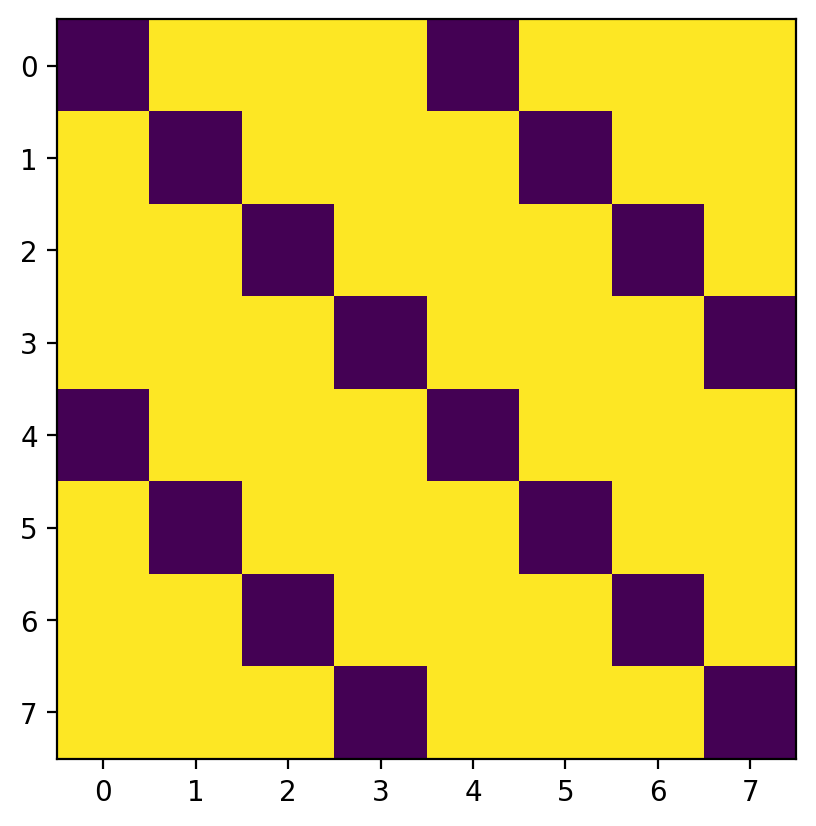

In [79]:
N_CHANNELS = 256
output_features_size = N_CHANNELS
PROJECTION_DIM = 128
projection_dim = PROJECTION_DIM
kernel_size = 3

In [80]:
conv_1 = nn.Conv1d(512, output_features_size, kernel_size=kernel_size, padding=1)
conv_2 = nn.Conv1d(
    output_features_size, output_features_size, kernel_size=kernel_size, padding=1
)
mp_1 = nn.MaxPool1d(2, 2)
conv_3 = nn.Conv1d(
    output_features_size, output_features_size, kernel_size=kernel_size, padding=1
)
conv_4 = nn.Conv1d(
    output_features_size, output_features_size, kernel_size=kernel_size, padding=1
)


def forward(x):
    x = F.relu(conv_1(x))
    print(x.shape)
    x = F.relu(conv_2(x))
    print(x.shape)
    x = mp_1(x)
    print(x.shape)
    x = F.relu(conv_3(x))
    print(x.shape)
    x = conv_4(x).mean(axis=2)
    print(x.shape)
    return x


projector = nn.Sequential(
    nn.Linear(output_features_size, output_features_size, bias=False),
    nn.ReLU(),
    nn.Linear(output_features_size, projection_dim, bias=False),
)

In [96]:
batch_size = 10
x_i = np.zeros((batch_size, 512, 60), dtype="float64")
x_j = np.zeros((batch_size, 512, 60), dtype="float64")

for i in range(batch_size):
    x_i[i] = i
    x_j[i] = i + np.random.rand() / 100

In [97]:
h_i = forward(torch.tensor(x_i, dtype=torch.float))
h_j = forward(torch.tensor(x_j, dtype=torch.float))

torch.Size([10, 256, 60])
torch.Size([10, 256, 60])
torch.Size([10, 256, 30])
torch.Size([10, 256, 30])
torch.Size([10, 256])
torch.Size([10, 256, 60])
torch.Size([10, 256, 60])
torch.Size([10, 256, 30])
torch.Size([10, 256, 30])
torch.Size([10, 256])


In [98]:
z_i = projector(h_i)
z_j = projector(h_j)

In [99]:
z_i.shape

torch.Size([10, 128])

In [28]:
image = np.random.rand(50, 100)
kernel = np.arange(9).reshape(3, -1)
padding = 1
strides = 1
kernel

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [29]:
kernel = np.flipud(np.fliplr(kernel))
xKernShape = kernel.shape[0]
yKernShape = kernel.shape[1]
xImgShape = image.shape[0]
yImgShape = image.shape[1]
xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)

In [30]:
xOutput
yOutput

50

100

In [76]:
if padding != 0:
    new_image = np.zeros((xImgShape + 2 * padding, yImgShape + 2 * padding))
    new_image[padding:-padding, padding:-padding] = image
new_image.shape

(54, 104)

In [ ]:
def convolve2D(image, kernel, padding=0, strides=1):
    kernel = np.flipud(np.fliplr(kernel))
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    if padding != 0:
        new_image = np.zeros((yImgShape + 2 * padding, xImgShape + 2 * padding))
        new_image[padding:-padding, padding:-padding] = image

In [40]:
class BasicNet(nn.Module):
    def __init__(self, output_features_size):
        super().__init__()
        self.output_features_size = output_features_size
        self.conv_1 = nn.Conv1d(512, output_features_size, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv1d(
            output_features_size, output_features_size, kernel_size=3, padding=1
        )
        self.mp_1 = nn.MaxPool1d(2, 2)
        self.conv_3 = nn.Conv1d(
            output_features_size, output_features_size, kernel_size=3, padding=1
        )
        self.conv_4 = nn.Conv1d(
            output_features_size, output_features_size, kernel_size=3, padding=1
        )

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = self.mp_1(x)
        x = F.relu(self.conv_3(x))
        x = self.conv_4(x).mean(axis=2)
        return x


class SimCLR(nn.Module):
    def __init__(self, encoder, projection_dim):
        super().__init__()
        self.encoder = encoder
        self.n_features = encoder.output_features_size
        self.projection_dim = projection_dim
        self.projector = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.ReLU(),
            nn.Linear(self.n_features, self.projection_dim, bias=False),
        )

    def forward(self, x_i, x_j):
        h_i = self.encoder(x_i)
        h_j = self.encoder(x_j)

        z_i = self.projector(h_i)
        z_j = self.projector(h_j)
        return h_i, h_j, z_i, z_j

In [103]:
N = 2 * batch_size
z = torch.cat((z_i, z_j), dim=0)
temperature = 0.1
#         sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
#         sim_i_j = torch.diag(sim, batch_size)
#         sim_j_i = torch.diag(sim, -batch_size)

#         mask = self.mask_correlated_samples(batch_size)
#         positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
#         negative_samples = sim[mask].reshape(N, -1)

#         labels = torch.zeros(N).to(positive_samples.device).long()
#         logits = torch.cat((positive_samples, negative_samples), dim=1)
#         loss = self.criterion(logits, labels)
#         loss /= N

In [109]:
similarity_f = nn.CosineSimilarity(dim=2)
sim = similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / temperature
sim_i_j = torch.diag(sim, batch_size)
sim_j_i = torch.diag(sim, -batch_size)

In [126]:
sim[2, 10]
sim[10, 2]

tensor(6.1197, grad_fn=<SelectBackward0>)

tensor(6.1197, grad_fn=<SelectBackward0>)

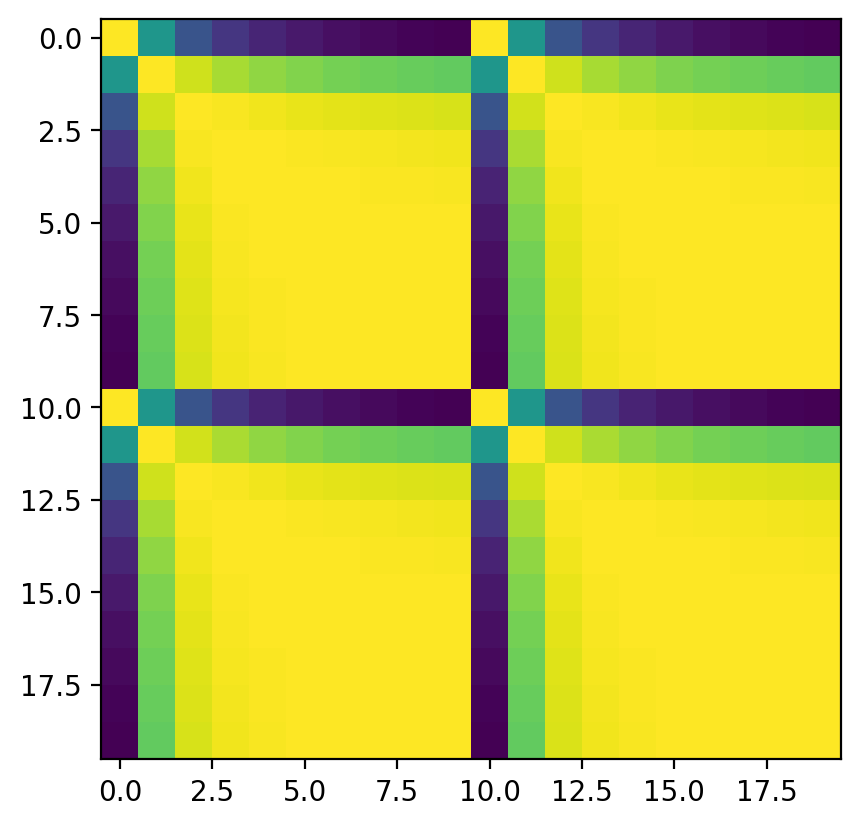

In [110]:
plt.imshow(sim.detach().numpy())

In [111]:
sim_i_j

tensor([ 9.9998, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000,
        10.0000, 10.0000], grad_fn=<DiagBackward0>)

In [112]:
sim_j_i

tensor([ 9.9998, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000,
        10.0000, 10.0000], grad_fn=<DiagBackward0>)

In [114]:
mask = mask_correlated_samples(batch_size)

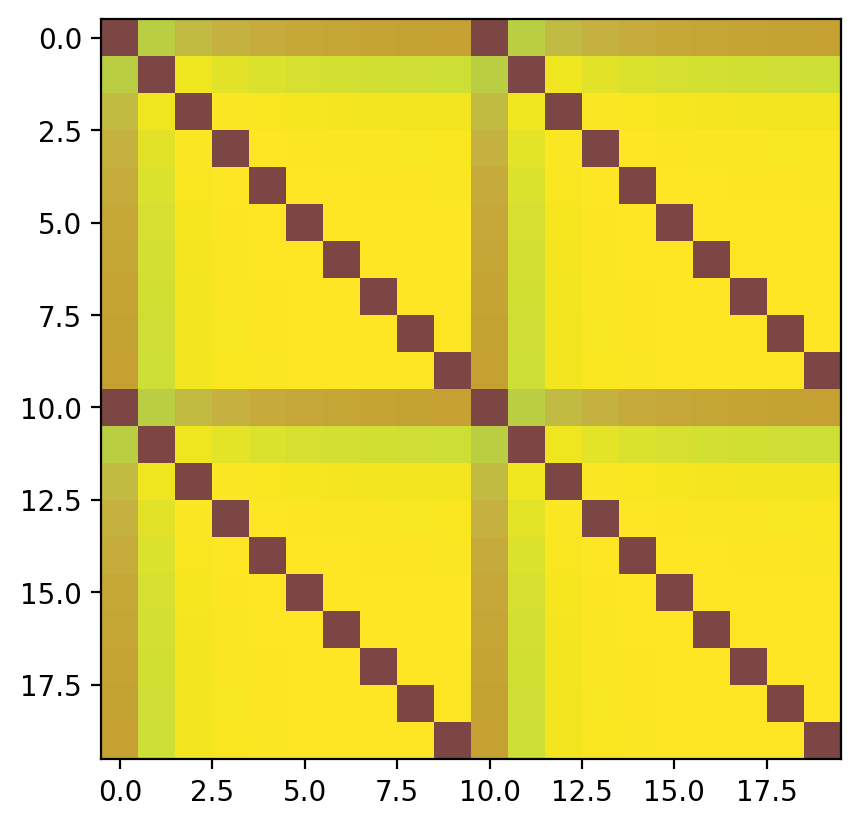

In [135]:
plt.imshow(sim.detach().numpy(), alpha=1)
plt.imshow(mask.numpy() * 1, alpha=0.7)

In [115]:
positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
negative_samples = sim[mask].reshape(N, -1)

In [132]:
negative_samples.shape

torch.Size([20, 18])

In [128]:
labels = torch.zeros(N).to(positive_samples.device).long()
logits = torch.cat((positive_samples, negative_samples), dim=1)

In [162]:
labels.shape
logits.shape

torch.Size([20])

torch.Size([20, 19])

In [141]:
negative_samples.topk(1)

torch.Size([20, 1])

In [142]:
avg_rank = logits.argsort(descending=True).argmin(dim=1).float().mean().cpu().numpy()

In [146]:
loss = nn.CrossEntropyLoss(reduction="sum")(logits, labels)

In [147]:
loss

tensor(47.8184, grad_fn=<NllLossBackward0>)

In [160]:
pdist = nn.PairwiseDistance(p=2, keepdim=False)
input1 = torch.tensor([[1, 2], [3, 4]])
input2 = torch.tensor([[1, 2], [3, 4]])
output = pdist(z_i.unsqueeze(1), z_j.unsqueeze(0))
output.shape

torch.Size([10, 10])

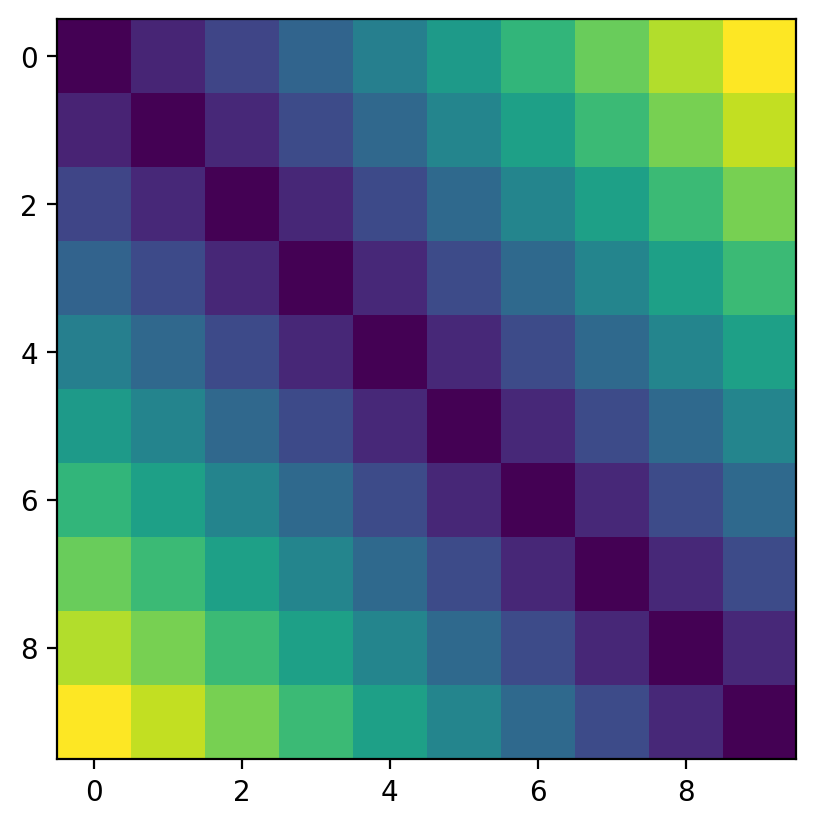

In [161]:
plt.imshow(output.detach().numpy(), alpha=1)

In [ ]:
# Loss & Metrics
class NT_Xent(nn.Module):
    def __init__(self, temperature):
        super(NT_Xent, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):  # z_i, z_j vectors from siamese model
        batch_size = z_i.shape[0]
        N = 2 * batch_size
        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, -batch_size)

        mask = self.mask_correlated_samples(batch_size)
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[mask].reshape(N, -1)

        labels = torch.zeros(N).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        with torch.no_grad():
            top1_negative_samples, _ = negative_samples.topk(1)
            avg_rank = (
                logits.argsort(descending=True)
                .argmin(dim=1)
                .float()
                .mean()
                .cpu()
                .numpy()
            )

        return loss, avg_rank

In [ ]:
def get_ranked_list(embeds, top_size, annoy_num_trees=32):
    annoy_index = None
    annoy2id = []
    id2annoy = dict()
    for track_id, track_embed in embeds.items():
        id2annoy[track_id] = len(annoy2id)
        annoy2id.append(track_id)
        if annoy_index is None:
            annoy_index = annoy.AnnoyIndex(len(track_embed), "angular")
        annoy_index.add_item(id2annoy[track_id], track_embed)
    annoy_index.build(annoy_num_trees)
    ranked_list = dict()
    for track_id in embeds.keys():
        candidates = annoy_index.get_nns_by_item(id2annoy[track_id], top_size + 1)[
            1:
        ]  # exclude trackid itself
        candidates = list(filter(lambda x: x != id2annoy[track_id], candidates))
        ranked_list[track_id] = [annoy2id[candidate] for candidate in candidates]
    return ranked_list


def position_discounter(position):
    return 1.0 / np.log2(position + 1)


def get_ideal_dcg(relevant_items_count, top_size):
    dcg = 0.0
    for result_indx in range(min(top_size, relevant_items_count)):
        position = result_indx + 1
        dcg += position_discounter(position)
    return dcg


def compute_dcg(query_trackid, ranked_list, track2artist_map, top_size):
    query_artistid = track2artist_map[query_trackid]
    dcg = 0.0
    for result_indx, result_trackid in enumerate(ranked_list[:top_size]):
        assert result_trackid != query_trackid
        position = result_indx + 1
        discounted_position = position_discounter(position)
        result_artistid = track2artist_map[result_trackid]
        if result_artistid == query_artistid:
            dcg += discounted_position
    return dcg


def eval_submission(submission, gt_meta_info, top_size=100):
    track2artist_map = gt_meta_info.set_index("trackid")["artistid"].to_dict()
    artist2tracks_map = gt_meta_info.groupby("artistid").agg(list)["trackid"].to_dict()
    ndcg_list = []
    for query_trackid in tqdm(submission.keys()):
        ranked_list = submission[query_trackid]
        query_artistid = track2artist_map[query_trackid]
        query_artist_tracks_count = len(artist2tracks_map[query_artistid])
        ideal_dcg = get_ideal_dcg(query_artist_tracks_count - 1, top_size=top_size)
        dcg = compute_dcg(
            query_trackid, ranked_list, track2artist_map, top_size=top_size
        )
        try:
            ndcg_list.append(dcg / ideal_dcg)
        except ZeroDivisionError:
            continue
    return np.mean(ndcg_list)


# Train & Inference functions


def inference(model, loader):
    embeds = dict()
    for tracks_ids, tracks_features in loader:
        with torch.no_grad():
            tracks_embeds = model(tracks_features)
            for track_id, track_embed in zip(tracks_ids, tracks_embeds):
                embeds[track_id] = track_embed.cpu().numpy()
    return embeds


def train(
    module,
    train_loader,
    val_loader,
    valset_meta,
    optimizer,
    criterion,
    num_epochs,
    checkpoint_path,
    top_size=100,
):
    max_ndcg = None
    for epoch in range(num_epochs):
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            module.train()
            x_i, x_j = batch[:, 0, :, :], batch[:, 1, :, :]
            h_i, h_j, z_i, z_j = module(x_i, x_j)
            loss, avg_rank = criterion(z_i, z_j)
            loss.backward()
            optimizer.step()
            print("Epoch {}/{}".format(epoch + 1, num_epochs))
            print("loss: {}".format(loss))
            print("avg_rank: {}".format(avg_rank))
            print()

        with torch.no_grad():
            model_encoder = module.encoder
            embeds_encoder = inference(model_encoder, val_loader)
            ranked_list_encoder = get_ranked_list(embeds_encoder, top_size)
            val_ndcg_encoder = eval_submission(ranked_list_encoder, valset_meta)

            model_projector = nn.Sequential(module.encoder, module.projector)
            embeds_projector = inference(model_projector, val_loader)
            ranked_list_projector = get_ranked_list(embeds_projector, top_size)
            val_ndcg_projector = eval_submission(ranked_list_projector, valset_meta)

            print("Validation nDCG on epoch {}".format(epoch))
            print("Encoder - {}".format(val_ndcg_encoder))
            print("Projector - {}".format(val_ndcg_projector))
            if (max_ndcg is None) or (val_ndcg_encoder > max_ndcg):
                max_ndcg = val_ndcg_encoder
                torch.save(model_encoder.state_dict(), checkpoint_path)


def save_submission(submission, submission_path):
    with open(submission_path, "w") as f:
        for query_trackid, result in submission.items():
            f.write("{}\t{}\n".format(query_trackid, " ".join(map(str, result))))


def main():
    parser = ArgumentParser(description="Simple naive baseline")
    parser.add_argument("--base-dir", dest="base_dir", action="store", required=True)
    args = parser.parse_args()

    # Seed
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    TRAINSET_DIRNAME = "train_features"
    TESTSET_DIRNAME = "test_features"
    TRAINSET_META_FILENAME = "train_meta.tsv"
    TESTSET_META_FILENAME = "test_meta.tsv"
    SUBMISSION_FILENAME = "submission.txt"
    MODEL_FILENAME = "model.pt"
    CHECKPOINT_FILENAME = "best.pt"
    device = "cuda" if torch.cuda.is_available() else "cpu"

    BATCH_SIZE = 512
    N_CHANNELS = 256
    PROJECTION_DIM = 128
    NUM_EPOCHS = 150
    LR = 1e-4
    TEMPERATURE = 0.1

    TRAINSET_PATH = os.path.join(args.base_dir, TRAINSET_DIRNAME)
    TESTSET_PATH = os.path.join(args.base_dir, TESTSET_DIRNAME)
    TRAINSET_META_PATH = os.path.join(args.base_dir, TRAINSET_META_FILENAME)
    TESTSET_META_PATH = os.path.join(args.base_dir, TESTSET_META_FILENAME)
    SUBMISSION_PATH = os.path.join(args.base_dir, SUBMISSION_FILENAME)
    MODEL_PATH = os.path.join(args.base_dir, MODEL_FILENAME)
    CHECKPOINT_PATH = os.path.join(args.base_dir, CHECKPOINT_FILENAME)

    sim_clr = SimCLR(encoder=BasicNet(N_CHANNELS), projection_dim=PROJECTION_DIM).to(
        device
    )

    train_meta_info = pd.read_csv(TRAINSET_META_PATH, sep="\t")
    test_meta_info = pd.read_csv(TESTSET_META_PATH, sep="\t")
    train_meta_info, validation_meta_info = train_val_split(
        train_meta_info, val_size=0.1
    )

    print("Loaded data")
    print("Train set size: {}".format(len(train_meta_info)))
    print("Validation set size: {}".format(len(validation_meta_info)))
    print("Test set size: {}".format(len(test_meta_info)))
    print()

    print("Train")
    train(
        module=sim_clr,
        train_loader=TrainLoader(
            FeaturesLoader(TRAINSET_PATH, train_meta_info, device),
            batch_size=BATCH_SIZE,
        ),
        val_loader=TestLoader(
            FeaturesLoader(TRAINSET_PATH, validation_meta_info, device),
            batch_size=BATCH_SIZE,
        ),
        valset_meta=validation_meta_info,
        optimizer=torch.optim.Adam(sim_clr.parameters(), lr=LR),
        criterion=NT_Xent(temperature=TEMPERATURE),
        num_epochs=NUM_EPOCHS,
        checkpoint_path=CHECKPOINT_PATH,
    )

    print("Submission")
    test_loader = TestLoader(
        FeaturesLoader(TESTSET_PATH, test_meta_info, device), batch_size=BATCH_SIZE
    )
    model = sim_clr.encoder
    embeds = inference(model, test_loader)
    submission = get_ranked_list(embeds, 100)
    save_submission(submission, SUBMISSION_PATH)
    torch.save(sim_clr.state_dict(), MODEL_PATH)


if __name__ == "__main__":
    main()